# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('../'))
from counterfactual_tpp import sample_counterfactual, superposition, combine, check_monotonicity, distance, covariance
from sampling_utils import homogenous_poisson, thinning, thinning_T

In [2]:
def normal(x, mean, sd, amp):  
    return amp * (1/(sd * (np.sqrt(2*np.pi)))) * np.exp(-0.5*((x-mean)/sd)**2)

def normal_1(x):  # original intensity
    mean = [5, 10, 15]
    sd = 1
    return normal(x, mean[0], sd, 1) + normal(x, mean[1], sd, 1) + normal(x, mean[2], sd, 1)

def  normal_2(x):  # intervened intensity
    mean = [6, 11, 16]
    sd = 1
    return normal(x, mean[0], sd, 1.5) + normal(x, mean[1], sd, 1.5) + normal(x, mean[2], sd, 1.5)
    # return np.full(x.shape, 0.4)

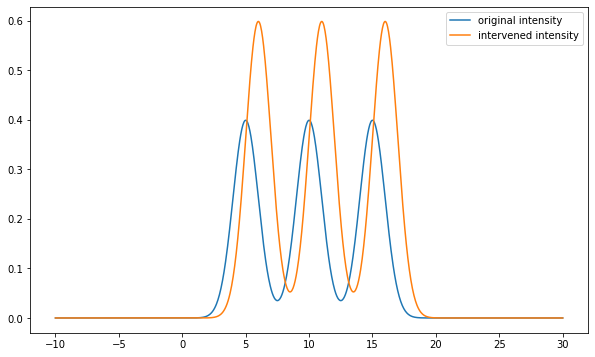

In [3]:
# plotting the intensities first
plt.figure(figsize=(10, 6))
x = np.linspace(-10, 30, 1000)
plt.plot(x, normal_1(x), label='original intensity')
plt.plot(x, normal_2(x), label='intervened intensity')
plt.legend()
# plt.savefig('../intensities.png', format = 'png', dpi = 900)
plt.show()

# Sampling From Lambda_max

In [43]:
# sampling from lambda_max, statring with zero
lambda_max = 0.6
T = 25
sample, indicators = thinning_T(0, intensity=normal_1, lambda_max=lambda_max, max_number_of_samples= 400, T=T)
accepted = [sample[i] for i in range(len(sample)) if indicators[i] == True]
lambdas = normal_1(np.asarray(sample))
sample = np.asarray(sample)
print('All events:\n', sample)
print('{} out of {} samples accepted.'.format(len(accepted), len(sample)))
print('accepted events:\n', accepted)
print('indicators:\n', indicators)

All events:
 [ 0.43631116  0.62539331  0.68523221  6.0022239   7.31337452 11.29939227
 11.55982997 11.98739869 14.10315154 14.6261343  15.4265487  15.95170999
 16.92159563 17.665923   17.71029721 18.25602375 21.64126234 21.69307473
 22.21275931 23.48307436]
6 out of 20 samples accepted.
accepted events:
 [6.002223897947391, 14.103151538862363, 14.626134298047008, 15.426548696330707, 15.951709993646155, 17.665922997146797]
indicators:
 [False, False, False, True, False, False, False, False, True, True, True, True, False, True, False, False, False, False, False, False]


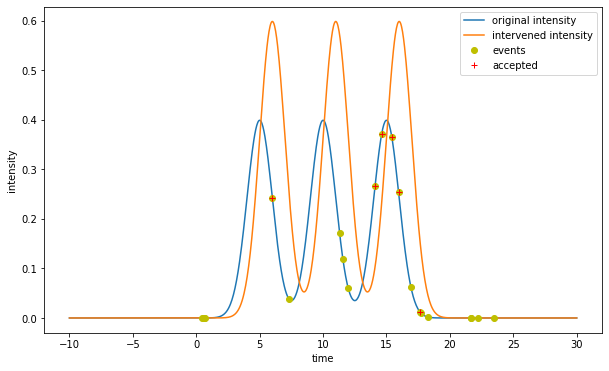

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(x, normal_1(x), label='original intensity')
plt.plot(x, normal_2(x), label='intervened intensity')
plt.plot(sample,lambdas, 'oy', label = 'events')
plt.plot(sample[indicators],lambdas[indicators], 'r+', label = 'accepted')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()
# plt.savefig('../sample_max.png', format = 'png', dpi = 900)

In [45]:
counterfactuals, counterfactual_indicators = sample_counterfactual(sample, lambdas, lambda_max, indicators, normal_2)
print('counterfactuals:\n', counterfactuals)
print(len(counterfactuals))

counterfactuals:
 [6.002223897947391, 11.299392271793597, 11.559829974649363, 11.987398691834144, 14.626134298047008, 15.426548696330707, 15.951709993646155, 16.92159563224004, 17.665922997146797]
9


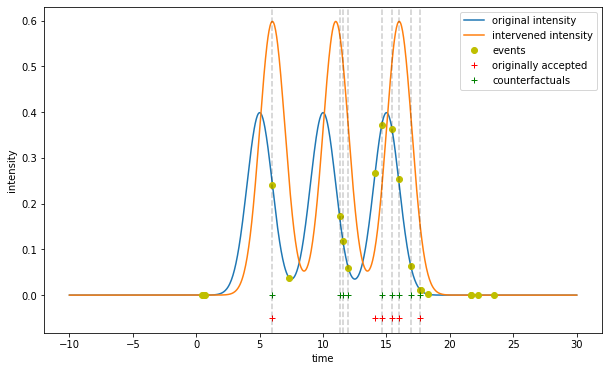

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(x, normal_1(x), label='original intensity')
plt.plot(x, normal_2(x), label='intervened intensity')
plt.plot(sample,lambdas, 'oy', label = 'events')
plt.plot(accepted,np.full(len(accepted), -0.05), 'r+', label = 'originally accepted')
plt.plot(counterfactuals,np.full(len(counterfactuals), 0), 'g+', label = 'counterfactuals')
for xc in counterfactuals:
    plt.axvline(x=xc, color = 'k', ls = '--', alpha = 0.2)
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()
# plt.savefig('../counter_max.png', format = 'png', dpi = 900)

As we can see, all of the accepted events that have higher intensity, are also accepted in the counter factual.

In [47]:
check_monotonicity(sample, counterfactuals, normal_1, normal_2, accepted) 

MONOTONIC


In [48]:
print('Distanse: {}'.format(distance(np.array(accepted), np.array(counterfactuals), T)))

Distanse: 37.334934968345216


In [49]:
cov = covariance(T, normal_1, normal_2, lambda_max)
print('Covariance: {}'.format(np.mean(cov)))

Covariance: -0.9756400000000001


In [50]:
cov

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.1539,  0.1499,  0.0716,
        0.0716,  0.0476,  0.1356, -0.5196, -0.1469, -0.5056, -2.5525,
       -2.7364, -2.7364, -2.7364, -2.7364, -2.7364, -2.7364])

# Real-World Scenario

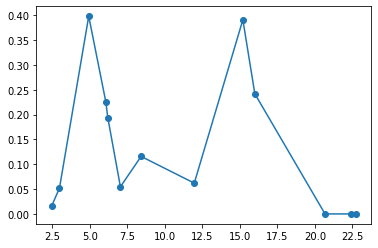

In [33]:
h_observed, lambda_observed, h_rejected, lambda_bar_rejected = superposition(lambda_max, normal_1, 200, T)
plt.plot(h_observed, lambda_observed, '-o')
# plt.savefig('../observed.png', format = 'png', dpi = 900)

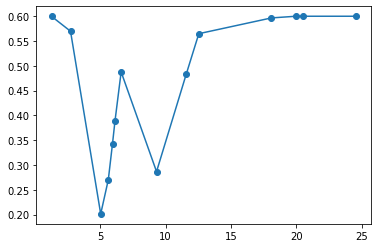

In [34]:
plt.plot(h_rejected, lambda_bar_rejected, '-o')
# plt.savefig('../superposition.png', format = 'png', dpi = 900)

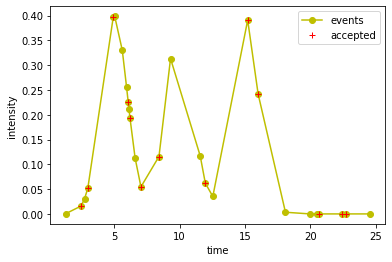

In [35]:
sample_rc, lambdas_rc, indicators_rc = combine(h_observed, lambda_observed, h_rejected, normal_1)
plt.plot(sample_rc,lambdas_rc, '-oy', label = 'events')
plt.plot(sample_rc[indicators_rc],lambdas_rc[indicators_rc], 'r+', label = 'accepted')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()
# plt.savefig('../combine.png', format = 'png', dpi = 900)

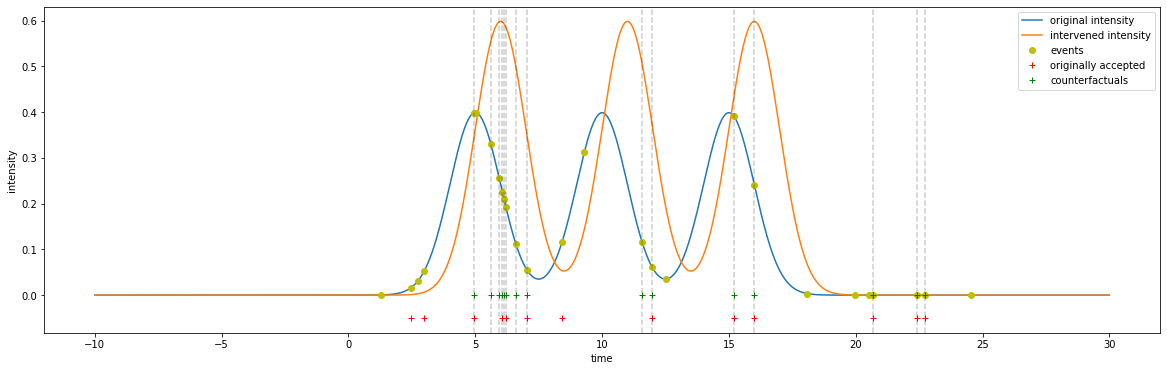

In [36]:
counterfactuals_rc, counterfactual_indicators_rc = sample_counterfactual(sample_rc, lambdas_rc, lambda_max, indicators_rc, normal_2)
plt.figure(figsize=(20, 6))
plt.plot(x, normal_1(x), label='original intensity')
plt.plot(x, normal_2(x), label='intervened intensity')
plt.plot(sample_rc,lambdas_rc, 'oy', label = 'events')
# plt.plot(sample_rc[indicators_rc],lambdas_rc[indicators_rc], 'r+', label = 'accepted')
# plt.plot(counterfactuals_rc, lambdas_rc[counterfactual_indicators_rc], 'g^', label = 'counterfactuals')
plt.plot(sample_rc[indicators_rc],np.full(len(sample_rc[indicators_rc]), -0.05), 'r+', label = 'originally accepted')
plt.plot(counterfactuals_rc,np.full(len(counterfactuals_rc), 0), 'g+', label = 'counterfactuals')
for xc in counterfactuals_rc:
    plt.axvline(x=xc, color = 'k', ls = '--', alpha = 0.2)
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()
# plt.savefig('../counter_real.png', format = 'png', dpi = 900)

In [11]:
check_monotonicity(sample_rc, counterfactuals_rc, normal_1, normal_2, h_observed)

MONOTONIC


In [12]:
print('Distanse: {}'.format(distance(np.array(sample_rc[indicators_rc]), np.array(counterfactuals_rc), 2 * 12)))

Distanse: 14.120519172190672
